# Bitcoin Price Forecasting-1: Simple Linear Regression Model

In this project, we build a simple forecasting model based on the linear regression for the Bitcoin 'Close' prices extracted from the 'Yahoo Finance' repository. The target variable is the 1-day ahead value (daily value) of Bitcoin and the inputs of the model are the historical values (n lags) of the target variable (autoregressive modeling). 

In [42]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import mplfinance as mplf
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.metrics as met
import statsmodels.graphics.tsaplots as tsaplt

## 1. Data Extraction

In [2]:
Ticker = 'BTC-USD'
Interval = '1d'
Date1 = dt.datetime(2015, 1, 1)
Date2 = dt.datetime(2022, 8, 1)

df_full = yf.download(tickers=Ticker, interval=Interval, start=Date1, end=Date2)

[*********************100%***********************]  1 of 1 completed


In [3]:
df_full

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
...,...,...,...,...,...,...
2022-07-28,22933.640625,24110.470703,22722.265625,23843.886719,23843.886719,40212386158
2022-07-29,23845.212891,24294.787109,23481.173828,23804.632812,23804.632812,35887249746
2022-07-30,23796.818359,24572.580078,23580.507812,23656.207031,23656.207031,28148218301


## 2. Initial Data Visualization

<AxesSubplot:xlabel='Date'>

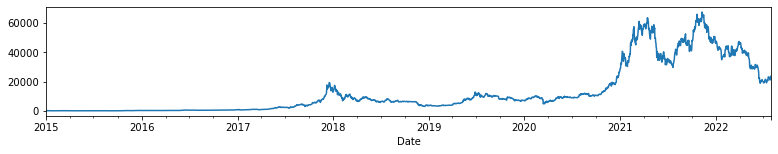

In [4]:
df_full.Open.plot(figsize=(13,2))

The default plot type of 'mplf' library is 'ohlc'. Other plot types can be specified with the keyword argument type, for example, type='candle', type='line', type='renko', or type='pnf'.

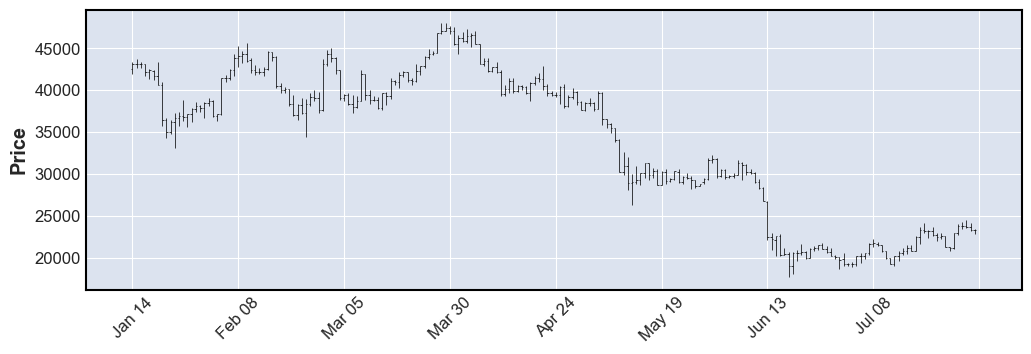

In [5]:
mplf.plot(df_full.iloc[-200:], figsize=(13,4))
plt.show()

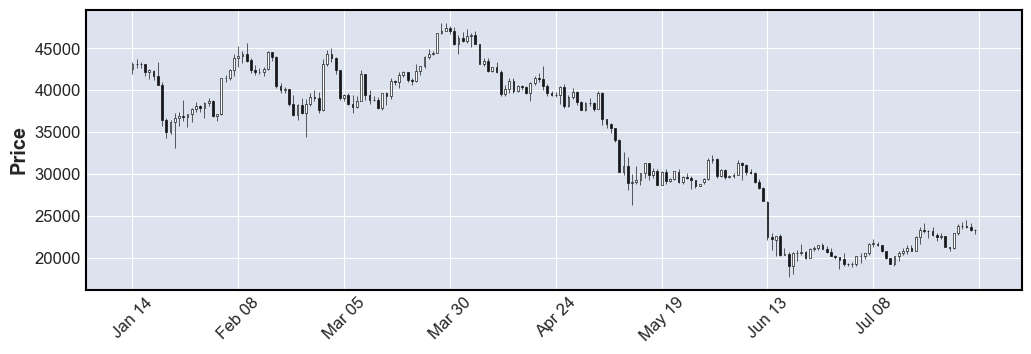

In [6]:
mplf.plot(df_full.iloc[-200:], type='candle', figsize=(13,4))
plt.show()

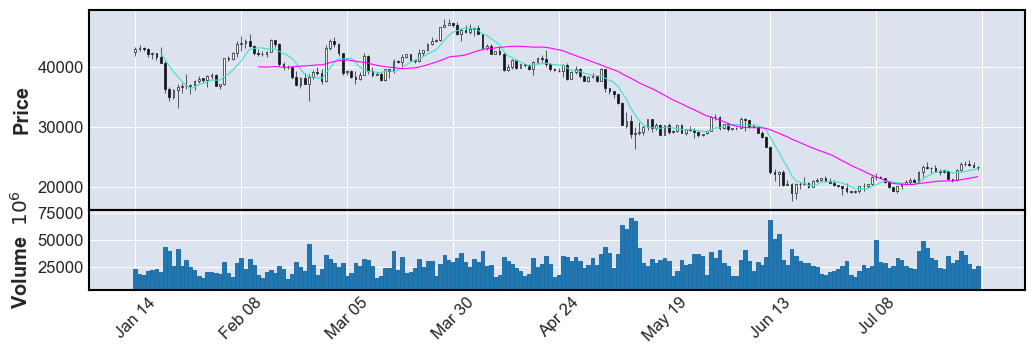

In [7]:
# showing 13 and 55 windows moving averages together with the values of 'volume' column.
mplf.plot(df_full.iloc[-200:], type='candle', mav=(7, 30), volume=True, figsize=(13,4))
plt.show()

## 3. Data Preprocessing

At this stage, we use 'close' values.

In [8]:
data_close = df_full['Close'].to_numpy()

In [9]:
# to restore plt defaults (it is changed by calling 'mplf')
plt.rcdefaults()

Text(0, 0.5, 'Price')

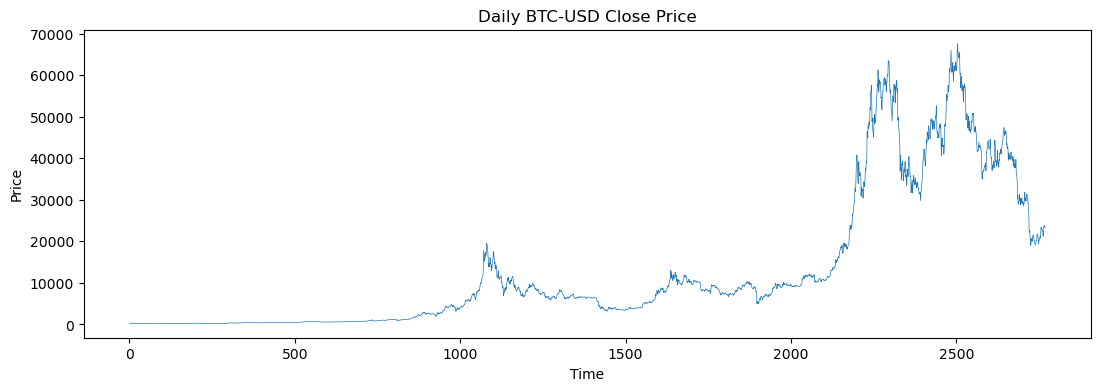

In [10]:
plt.figure(figsize=(13,4))
plt.plot(data_close, linewidth=0.5)
plt.title('Daily BTC-USD Close Price')
plt.xlabel('Time')
plt.ylabel('Price')

Due to the huge price jumps, the changes in the first 700 data points cannot be seen. So, we plot the 'log' of the data. 

Text(0, 0.5, 'Log Price')

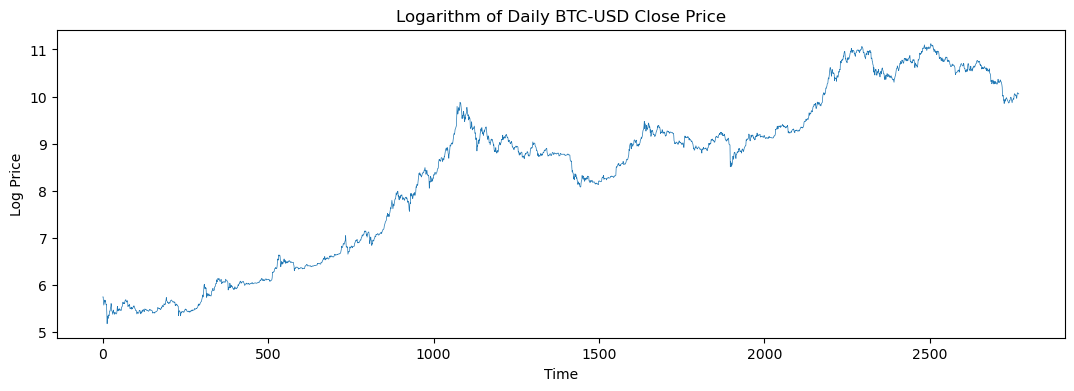

In [11]:
data_close_log = np.log(data_close)

plt.figure(figsize=(13,4))
plt.plot(data_close_log, linewidth=0.5)
plt.title('Logarithm of Daily BTC-USD Close Price')
plt.xlabel('Time')
plt.ylabel('Log Price')

We generate data windows using a Lag function which is defined as follows:

In [12]:
data_close_log.size

2770

In [13]:
def Lag(data, input_width):
    window_number = data.size - input_width
    X = np.zeros((window_number, input_width))
    Y = np.zeros((window_number, 1))
    for i in range(window_number):
        X[i,:] = data[i:i+input_width] # input
        Y[i,0] = data[i+input_width] # target
    return X, Y

In [14]:
X0, Y0 = Lag(data=data_close_log, input_width=30)
X0.shape, Y0.shape

((2740, 30), (2740, 1))

We split the data into train and test sets as follows:

In [15]:
train_split = 0.8
split_num = int(train_split * data_close_log.size)

X0_train = X0[:split_num]
Y0_train = Y0[:split_num]
X0_test = X0[split_num:]
Y0_test = Y0[split_num:]

(X0_train.shape, Y0_train.shape) , (X0_test.shape, Y0_test.shape)

(((2216, 30), (2216, 1)), ((524, 30), (524, 1)))

We standardize the data based on the training set.

In [16]:
scale_X = pp.StandardScaler().fit(X0_train)
X0_train_std = scale_X.transform(X0_train)
X0_test_std = scale_X.transform(X0_test)

scale_Y = pp.StandardScaler().fit(Y0_train)
Y0_train_std = scale_Y.transform(Y0_train)
Y0_test_std = scale_Y.transform(Y0_test)

## 4. Modeling

Training a simple linear regression model:

In [19]:
model_LR = lm.LinearRegression()
model_LR.fit(X0_train_std, Y0_train_std)

LinearRegression()

Defining a function for model evaluation:

In [25]:
def model_eval(model, inputs, target):
    prediction = model.predict(inputs)

    MSE = met.mean_squared_error(target, prediction)
    RMSE = np.sqrt(MSE)
    NRMSE = (RMSE * 100)/(np.max(target) - np.min(target))
    MAE = met.mean_absolute_error(target, prediction)
    R2 = 100 * met.r2_score(target, prediction)

    print(f'MSE:   {round(MSE, 4)}')
    print(f'RMSE:  {round(RMSE, 4)}')
    print(f'NRMSE: {round(NRMSE, 2)} %')
    print(f'MAE:   {round(MAE, 4)}')
    print(f'R2:    {round(R2, 2)} %')

In [27]:
print('Performance of the linear regression model on the training set:')
model_eval(model_LR, X0_train_std, Y0_train_std)
print('='*60)
print('Performance of the linear regression model on the test set:')
model_eval(model_LR, X0_test_std, Y0_test_std)

Performance of the linear regression model on the training set:
MSE:   0.0007
RMSE:  0.0259
NRMSE: 0.68 %
MAE:   0.0167
R2:    99.93 %
Performance of the linear regression model on the test set:
MSE:   0.0007
RMSE:  0.0263
NRMSE: 3.08 %
MAE:   0.0192
R2:    98.28 %


Visualizing the predictions:

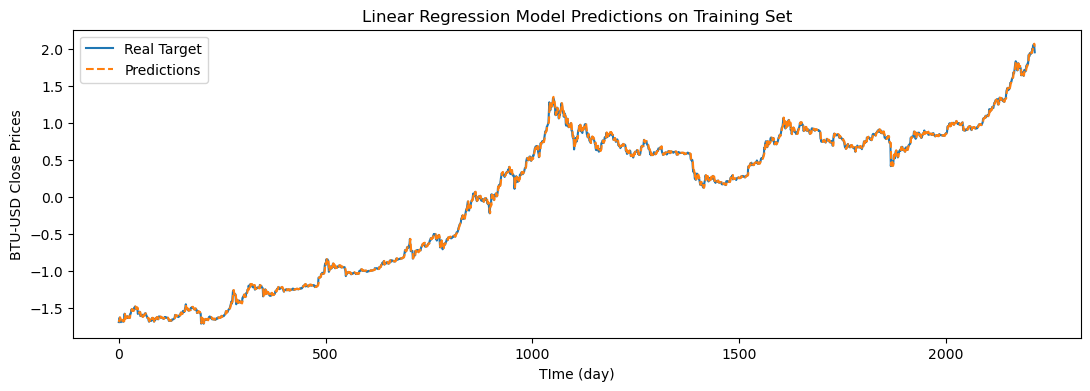

In [39]:
train_pred = model_LR.predict(X0_train_std)

plt.figure(figsize=(13,4))
plt.plot(Y0_train_std, linewidth=1.5, label='Real Target')
plt.plot(train_pred, linewidth=1.5, linestyle='dashed', label='Predictions')
plt.title('Linear Regression Model Predictions on Training Set')
plt.xlabel('TIme (day)')
plt.ylabel('BTU-USD Close Prices')
plt.legend()
plt.show()

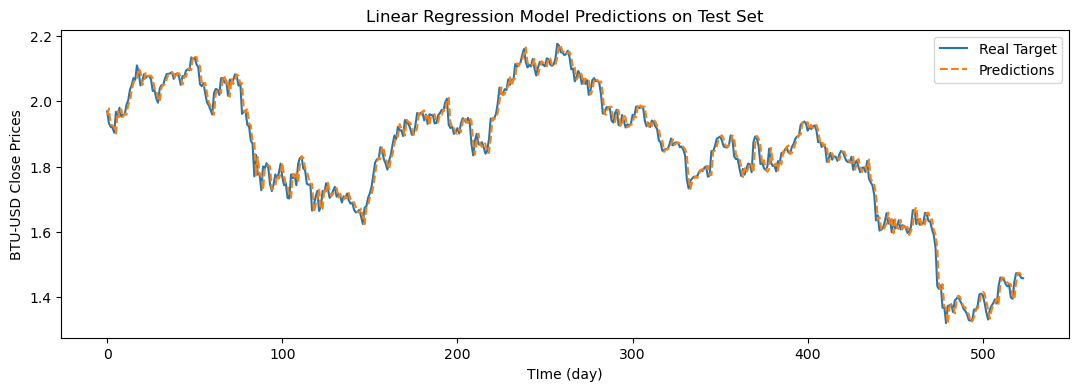

In [40]:
test_pred = model_LR.predict(X0_test_std)

plt.figure(figsize=(13,4))
plt.plot(Y0_test_std, linewidth=1.5, label='Real Target')
plt.plot(test_pred, linewidth=1.5, linestyle='dashed', label='Predictions')
plt.title('Linear Regression Model Predictions on Test Set')
plt.xlabel('TIme (day)')
plt.ylabel('BTU-USD Close Prices')
plt.legend()
plt.show()

The coefficients of the input variables (30 lags of the target) are as follows:

In [41]:
model_LR.coef_

array([[ 4.04231690e-02, -2.67810590e-02, -1.46023924e-02,
        -1.12099241e-02,  2.27790784e-02,  1.09592851e-02,
        -2.48131467e-03, -1.41109638e-02,  3.53806028e-02,
        -6.39254180e-02, -2.37286831e-02,  4.40598062e-02,
        -3.92853431e-02,  4.82083499e-02, -8.29643037e-03,
         7.25404177e-04,  5.55018237e-03, -1.76160306e-02,
        -4.44781224e-03, -3.71195209e-02,  8.35836137e-02,
        -2.13332381e-02,  2.81397849e-02, -9.06008702e-02,
         3.11793253e-02,  1.89212502e-02, -1.90936905e-03,
        -5.41191017e-03,  3.58990849e-02,  9.76688745e-01]])

The biggest coefficient is for the last input variable (lag of 1) with a value of 0.976. This means that the output of the model mainly relys on the last recorded target value (the 'Close' price of today, if we are forecasting the price for tommorow). 

We can find the most important lags by analyzing the autocorrelation for the variable and visualizing the partial autocorrelation function (PACF). Then, the most efficient number of the lags can be derived in order to build a model with an acceptable performance. 

c:\Users\MIO\.conda\envs\envtf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


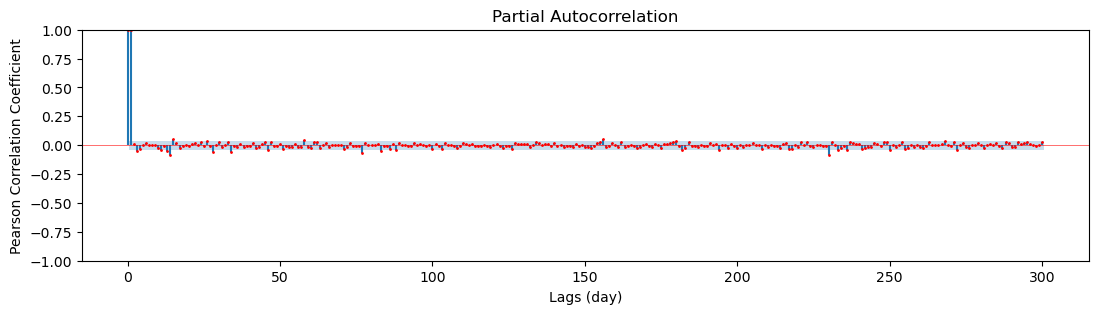

In [54]:
plt.rc("figure", figsize=(13,3))
tsaplt.plot_pacf(data_close_log, lags=300, color='red', linewidth=0.4, markersize=1)
plt.xlabel('Lags (day)')
plt.ylabel('Pearson Correlation Coefficient')
plt.show()


As can be seen in the above plot, the correlation values are very small for all the lags, except for lag 1.

Other models can be trained over the dataset and compared with the developed model.

-----
-----
END 